In [1]:
import os, sys, time, warnings
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')

import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit, grad, random, jacfwd, config
from jax.lax import map
config.update("jax_enable_x64", True)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
matplotlib.rc('font', size=16, family='serif')
# matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)

import numpyro
from getdist import plots,MCSamples,loadMCSamples
numpyro.enable_x64()

from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference

%config InlineBackend.figure_format = 'retina'

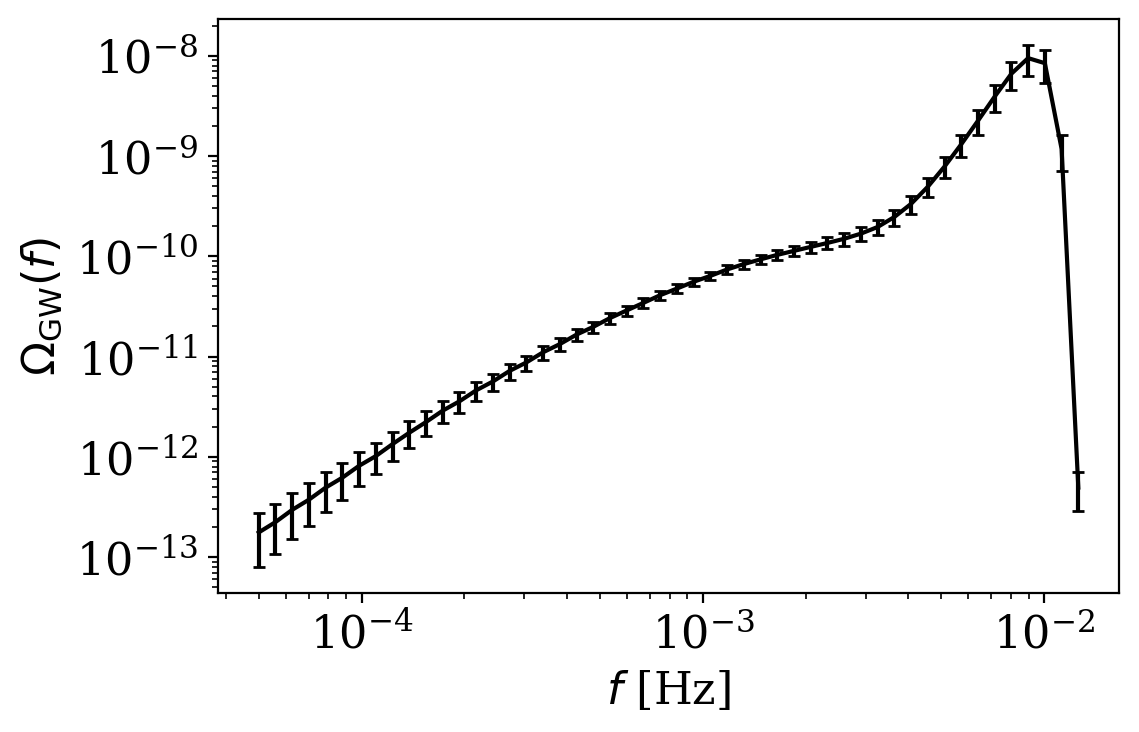

In [2]:
# load the gwb data from file and plot it
data = np.load('../bpl_ker_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

#### Nautilus free nodes

In [3]:
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 250)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

k_max = 10**(-2) # Wavenumber at transition to RD
eta_R = 20/k_max # Conformal time at the end of RD
params = [k_max, eta_R]

gwb_calculator = OmegaGWjax(s=s,t=t,f=frequencies,norm="RD",kernel="I_MD_to_RD",jit=True)

num_nodes = 4
free_nodes = num_nodes - 2
pk_min, pk_max = min(p_arr), max(p_arr)
left_node, right_node = np.log10(pk_min), np.log10(pk_max)
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)
y_max = -6
y_min = -2
y_mins = np.array([-6,-6,-6,-6])
y_maxs = np.array([-2,-2,-2,-2])


def prior_1D(cube):
    # Order and transform nodes to be in the correct range, from Polychord SortedUniformPrior
    # params = np.atleast_2d(cube.copy())
    params = cube.copy()
    x = params[:free_nodes]
    # x = params[:,:free_nodes]
    # Npoints = cube.shape[0]
    N = free_nodes
    t = np.zeros(N)
    t[N-1] = x[N-1]**(1./N)
    for n in range(N-2, -1, -1):
        t[n] = x[n]**(1./(n+1)) * t[n+1]
    xs = t*(right_node - left_node) + left_node
    ys = params[free_nodes:]
    ys = ys*(y_max - y_min) + y_min
    return np.concatenate([xs,ys]) # array


def prior(cube):
    """
    Transforms the input cube from [0,1] uniform parameters to the desired prior space.
    This vectorized version supports cube being either a 1D array of shape (nd,)
    or a 2D array of shape (Npoints, nd).
    
    The cube is assumed to be structured as follows:
      - The first 'free_nodes' values correspond to the x parameters.
      - The remaining values correspond to the y parameters.
    
    Global variables used:
      free_nodes: int, number of nodes for the x parameters (also called N)
      left_node, right_node: floats defining the transformation range for x.
      y_min, y_max: floats defining the transformation range for y.
    """
    # Ensure cube is at least 2D (1D arrays are treated as a single row)
    cube = np.atleast_2d(cube.copy())
    
    N = free_nodes  # Number of x parameters
    # Extract x parameters (shape: (Npoints, free_nodes))
    x = cube[:, :N]
    
    # Create an array of exponents: 1/(1), 1/(2), ..., 1/(N)
    exponents = 1.0 / np.arange(1, N+1)
    # Raise x to the corresponding exponents, broadcasting over the rows
    # This gives an array 'y' of shape (Npoints, free_nodes)
    y = x ** exponents
    
    # Compute the reverse cumulative product along the second axis.
    # Step 1: Reverse the order of columns.
    # Step 2: Compute cumulative product along axis=1.
    # Step 3: Reverse the result back.
    t = np.cumprod(y[:, ::-1], axis=1)[:, ::-1]
    
    # Transform the cumulative product to the desired x space.
    xs = t * (right_node - left_node) + left_node
    
    # Process the y parameters (the remaining columns)
    ys = cube[:, N:]
    ys = ys * (y_maxs[None,:] - y_mins[None,:]) + y_mins[None,:]
    # Concatenate the transformed x and y parameters along the second axis.
    return np.concatenate([xs, ys], axis=1)


from interpax import CubicSpline
from functools import partial
# from jax import lax

# def check_bounds(x):
#     # if x out of bounds return 0
#     lax.cond()

# @jit
def interpolate(nodes,vals,x):
    # nodes = jnp.pad(nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    spl = CubicSpline(nodes,vals,check=False)
    res = jnp.power(10,spl(x))
    res = jnp.where(x<left_node, 0, res)
    res = jnp.where(x>right_node, 0, res)
    return res

    
def get_gwb(nodes,vals):
    pf = lambda k, *args: interpolate(nodes,vals,jnp.log10(k))
    omegagw = gwb_calculator(pf,frequencies,*params)
    return (omegagw,)

get_gwb_func = jax.jit(get_gwb)

from sigw_utils import split_vmap

def likelihood(params):
    # print(params)
    params = jnp.atleast_2d(params)
    nodes = params[:,:free_nodes]
    # print(nodes)
    nodes = jnp.pad(nodes, ((0,0),(1,1)), 'constant', constant_values=((0,0),(left_node, right_node)))
    # print(nodes)
    vals = params[:,free_nodes:]
    omegagw = split_vmap(get_gwb_func,(nodes,vals),batch_size=20)[0]
    # pf = lambda x: interpolate(nodes,vals,jnp.log10(x))
    # omegagw = gwb_calculator(pf,frequencies)
    # print(omegagw.shape)
    diff = omegagw - Omegas
    sol = np.linalg.solve(cov, diff.T).T
    res = -0.5 * np.sum(diff * sol, axis=1)
    # res = -0.5 * np.dot(diff, np.linalg.solve(cov,diff))
    res = np.where(np.isnan(res),-1e10, res)
    res = np.where(res<-1e10,-1e10, res)
    return res


5.00000000000001e-06 0.01000000000000001


In [4]:

from nautilus import Sampler

ndim = free_nodes + num_nodes
# np.random.seed(42)
# x = np.random.uniform(0,1,size=(10,ndim))

# # print(prior(x).shape)
# print(likelihood(x[2]).shape)

# print(x[2])

# print(prior(x[2]))

# print(prior_1D(x[2]))
sampler = Sampler(prior, likelihood, ndim, pass_dict=False,vectorized=True)
start = time.time()
sampler.run(verbose=True,f_live=0.01,n_like_max=1e6,n_eff=5000)
end = time.time()
print('Time taken: {:.2f} s'.format(end-start))
print('log Z: {:.2f}'.format(sampler.log_z))

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 5        | 4        | 71800    | N/A    | 5027  | -13.43   
Time taken: 583.15 s
log Z: -13.43


In [11]:
samples, logl, logwt = sampler.posterior()

print(samples.shape)
print(logl.shape)
print(logwt.shape)

import math
SQRTEPS = math.sqrt(float(np.finfo(np.float64).eps))
def resample_equal(samples,logl, logwt, rstate):
    # Extract the weights and compute the cumulative sum.
    wt = np.exp(logwt - logwt.max())
    weights = wt / wt.sum()

    cumulative_sum = np.cumsum(weights)

    # if abs(cumulative_sum[-1] - 1.) > SQRTEPS:
    #     # same tol as in numpy's random.choice.
    #     # Guarantee that the weights will sum to 1.
    #     warnings.warn("Weights do not sum to 1 and have been renormalized.")
    cumulative_sum /= cumulative_sum[-1]
    # this ensures that the last element is strictly == 1

    # Make N subdivisions and choose positions with a consistent random offset.
    nsamples = len(weights)
    print(nsamples)

    positions = (rstate.random() + np.arange(nsamples)) / nsamples
    
    # Resample the data.
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
            if j == nsamples:
                break
    
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    return resampled_samples, resampled_logl

rstate = np.random.default_rng(100000)
samples, lp = resample_equal(samples,logl,logwt, rstate=rstate)

print("Obtained equally weighted samples")
print(f"Max and min logprob: {np.max(lp)}, {np.min(lp)}")
print(len(lp))

# samples = samples[lp>-10,:]

(71800, 6)
(71800,)
(71800,)
71800
Obtained equally weighted samples
Max and min logprob: -4.578727071591189, -15.678025390922702
71800


(513, 100)
(513, 50)
(100,) (100,)


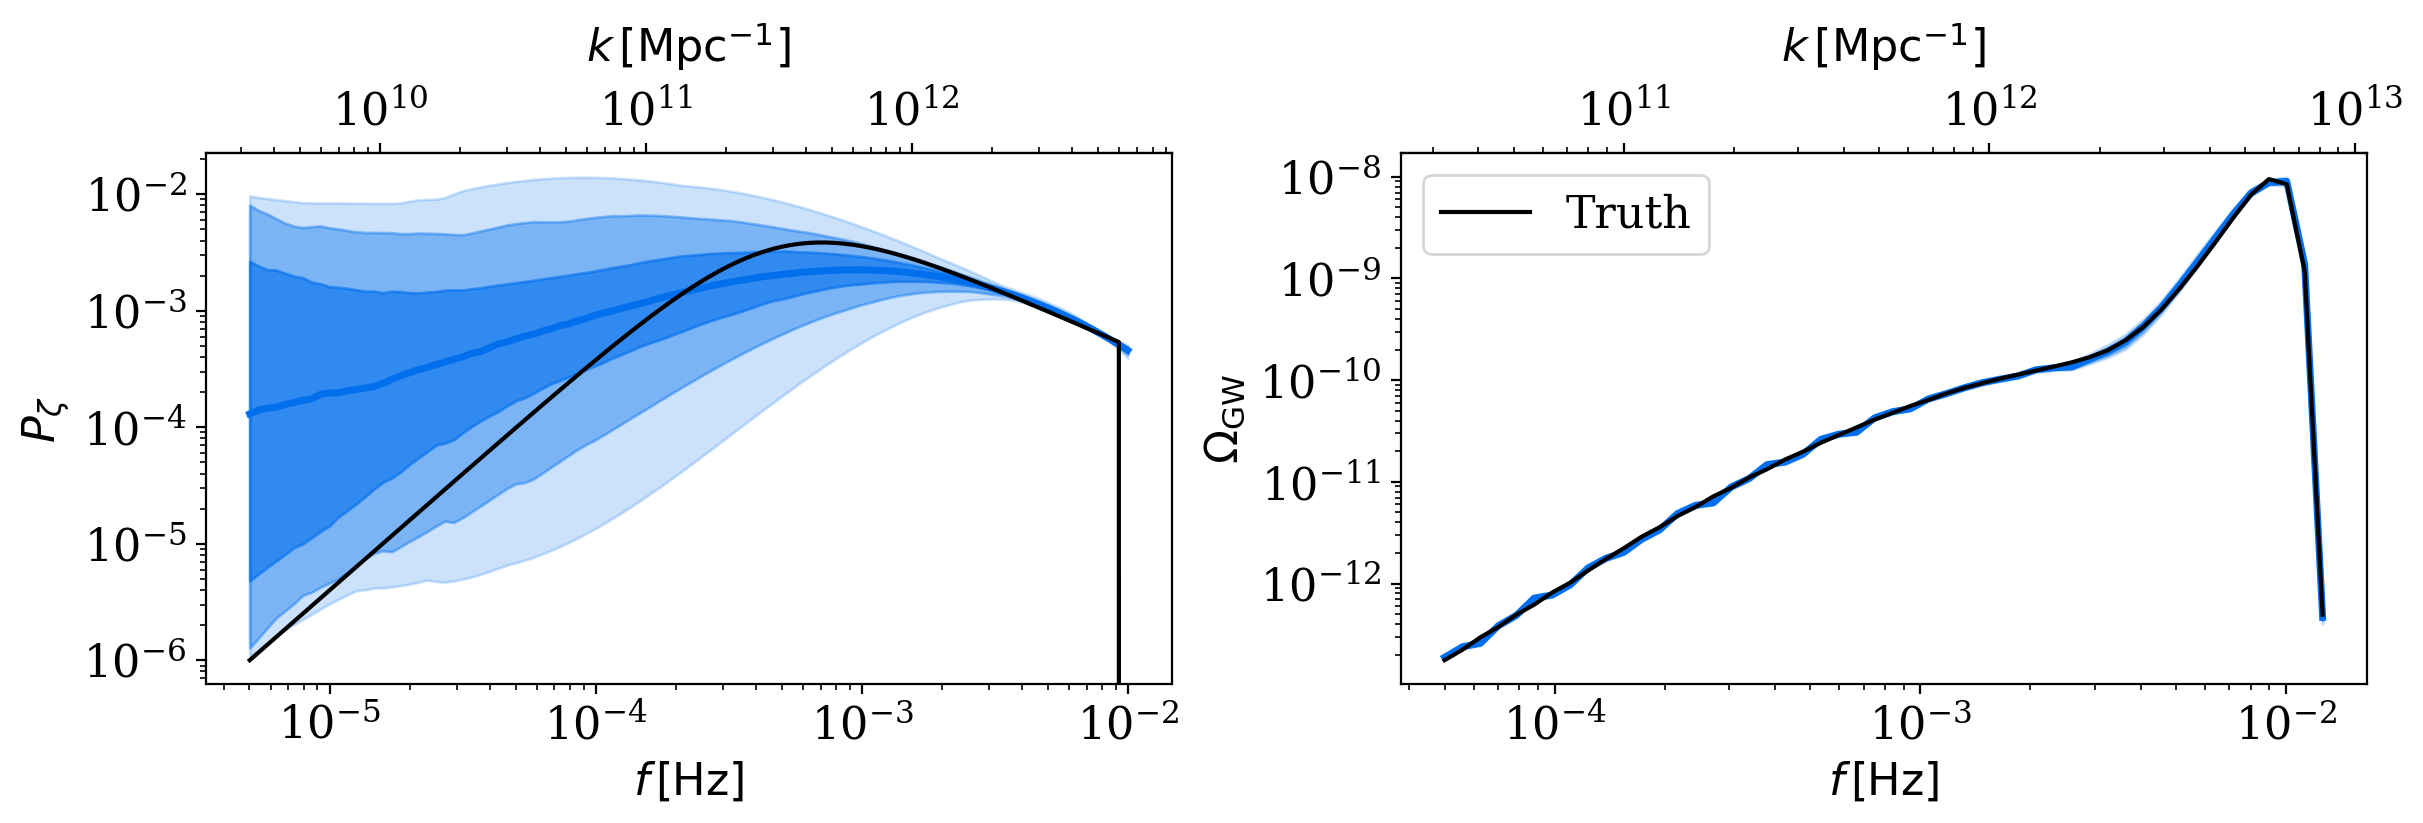

In [13]:
# Plot the functional posterior

def plot_functional_posterior(vals = [],k_arr = [], intervals = [99.7,95.,68.],
                              ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,5)
                              , interval_cols = [('#006FED',0.2),('#006FED',0.4),('#006FED',0.6)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(val,[50-interval/2,50+interval/2],axis=0)
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(val,axis=0),color='#006FED',lw=2.5)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$f\,{\rm [Hz]}$')
    return fig, ax 

p_arr = jnp.logspace(left_node+0.001,right_node-0.001,100)

gd_colors = ['#006FED', '#E03424']

def get_pz_omega(nodes,vals):
    pf = lambda k, *args: interpolate(nodes,vals,jnp.log10(k))
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,frequencies, *params)
    return (pz_amps, gwb_res)

thinning = samples.shape[0] // 512
xs, ys = samples[:,:free_nodes][::thinning], samples[:,free_nodes:][::thinning]

xs = jnp.pad(xs, ((0,0),(1,1)), 'constant', constant_values=((0,0),(left_node, right_node)))
ys = jnp.array(ys)
pz_amps,gwb_amps = split_vmap(get_pz_omega,(xs,ys),batch_size=32)


print(pz_amps.shape)
print(gwb_amps.shape)

print(p_arr.shape,pz_amp.shape)

fig, ax = plot_functional_posterior([pz_amps,gwb_amps],k_arr=[p_arr,frequencies],aspect_ratio=(6,4))
ax[0].loglog(p_arr,pz_amp,color='k',lw=1.5)
ax[1].loglog(frequencies,Omegas, color='k',lw=1.5,label='Truth')
ax[1].legend()

# add k-labels on top
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
# ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.savefig(f'bpl_{num_nodes}.pdf',bbox_inches='tight')



Removed no burn in


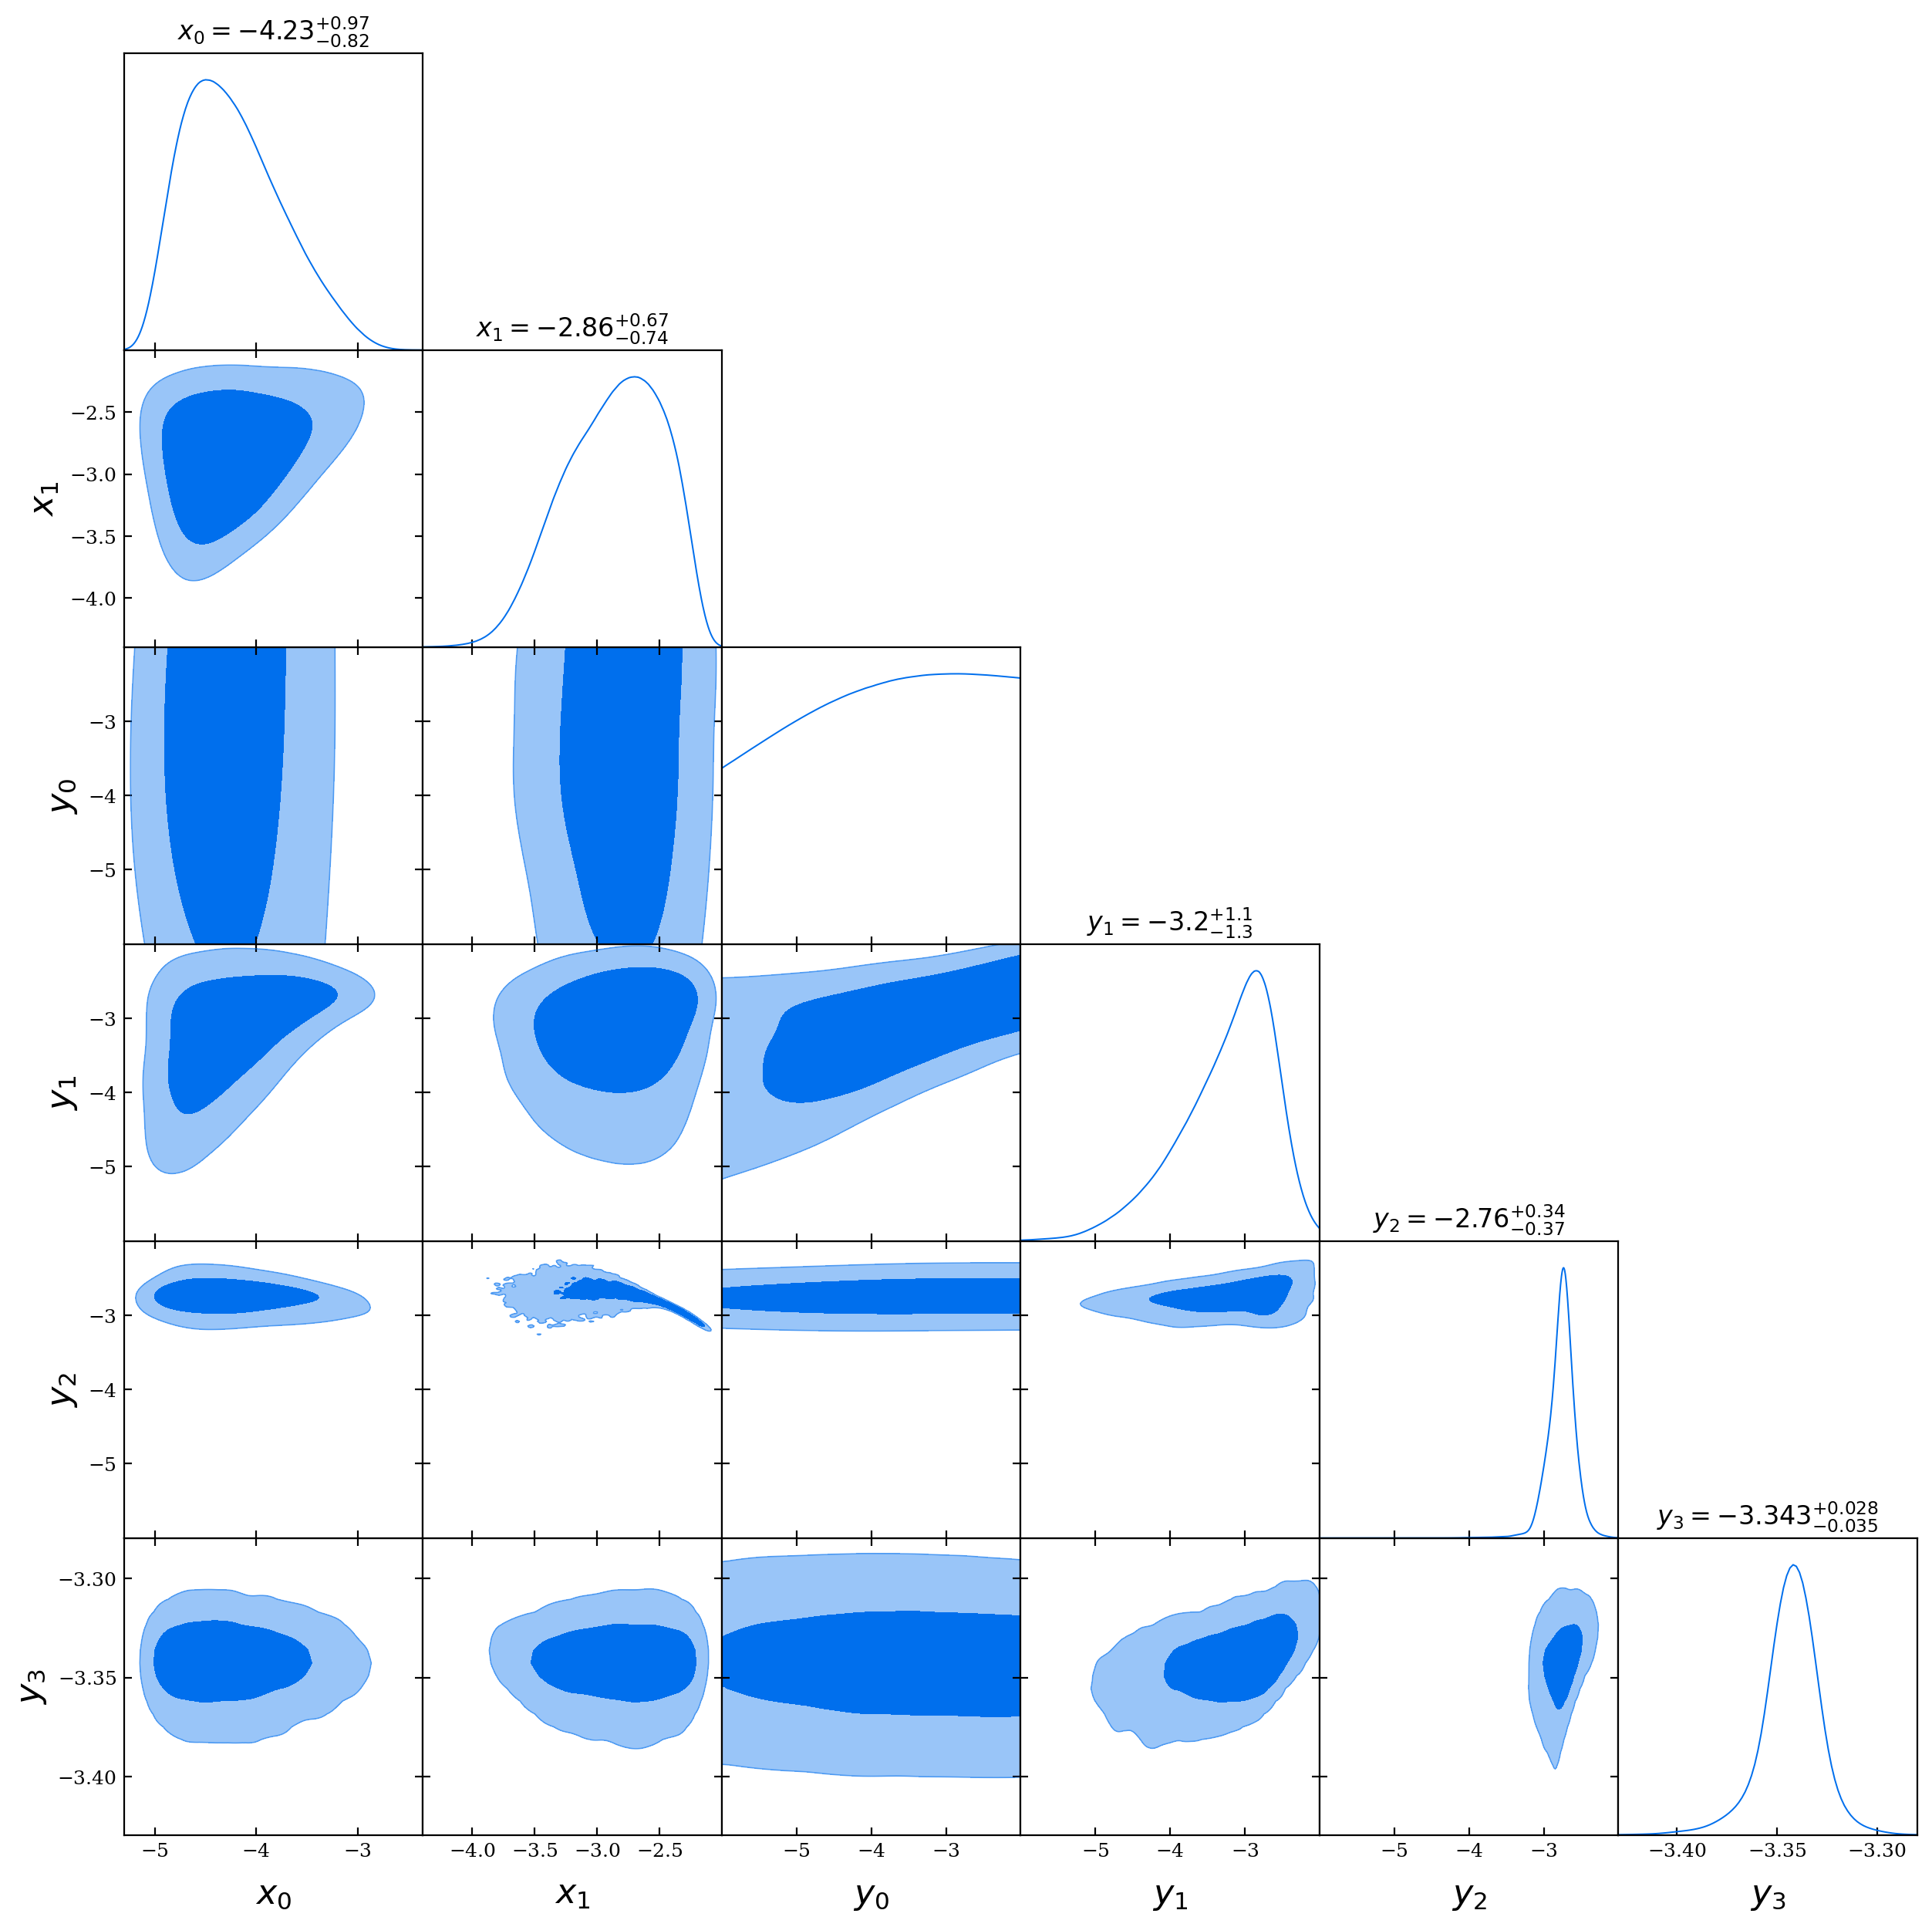

In [7]:
# plot posteriors for the parameters

samples, logl, logwt = sampler.posterior()
# renormalise weights
from scipy.special import logsumexp
log_total = logsumexp(logwt)
weights = np.exp(logwt - log_total)

names = [f'x{i}' for i in range(free_nodes)] + [f'y{i}' for i in range(num_nodes)]
labels = [f'x_{i}' for i in range(free_nodes)] + [f'y_{i}' for i in range(num_nodes)]
ranges = {}
for i in range(free_nodes):
    ranges[f'x{i}'] = (left_node,right_node)
for i in range(num_nodes):
    ranges[f'y{i}'] = (y_mins[i],y_maxs[i])
gdsamples = MCSamples(samples=samples,names=names,labels=labels,ranges=ranges,weights=weights,loglikes=logl)
# print(f"R-1 = {gdsamples.Conv()}")
g = plots.get_subplot_plotter(subplot_size=2.5)
g.settings.legend_fontsize = 14
g.settings.axes_labelsize = 18
g.settings.title_limit_fontsize = 14
g.triangle_plot(gdsamples, filled=True, params=names,title_limit=2)

### Results

N = 3
Time taken: 1710.15 s
log Z: -47.89

N = 4
log Z: -100

N = 5
Time taken: 1483.20 s
log Z: -16.43

N = 6
Time taken: 3223.93 s
log Z: -16.90
